In [1]:
import pickle
from scipy.sparse import csr_matrix
from clustering import visualize_silhouette_clusters, compare_true_labels
import numpy as np
from kmodes.kmodes import KModes
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_distances
from soyclustering import SphericalKMeans, visualize_pairwise_distance
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.datasets import fetch_20newsgroups

with open('data/appliancesreviews/minsupp_0.3/itemset_features.pkl', 'rb') as f:
    itemset_features = pickle.load(f)
    
with open('data/appliances_reviews_labels.pkl', 'rb') as f:
    true_labels = pickle.load(f)
    
print("num of groundtruth labels:", len(np.unique(true_labels)))

num of groundtruth labels: 5


In [2]:
# adjust number of clusters
my_num_clusters = 5

# convert itemset_features to a sparse matrix that SphericalKMeans will accept
itemset_matrix = csr_matrix(itemset_features.astype(int))
density = itemset_matrix.getnnz() / np.prod(itemset_matrix.shape)
print("density of matrix:", density)

spherical_kmeans = SphericalKMeans(
        n_clusters=my_num_clusters,
        max_iter=100,
        verbose=1,
        init='similar_cut',
        #sparsity='minimum_df',
        minimum_df_factor=0.05
    )

results = []
i=0
while len(results)<10:
    try:
        i+=1
        print('\nRun #' + str(i))
        sphkmeans_cluster_labels = spherical_kmeans.fit_predict(itemset_matrix)
        result = compare_true_labels(true_labels, sphkmeans_cluster_labels, itemset_features)
        results.append(result)
    except Exception as e:
        # sometimes spherical clustering fails due to the initialization, re-run
        print(e)
        continue 

density of matrix: 0.3759521095638891

Run #1
initialization_time=0.001997 sec, sparsity=0.301
n_iter=1, changed=2171, inertia=1267.851, iter_time=1.132 sec, sparsity=0.213
n_iter=2, changed=28, inertia=834.395, iter_time=1.140 sec, sparsity=0.215
n_iter=3, changed=61, inertia=825.192, iter_time=1.121 sec, sparsity=0.215
n_iter=4, changed=17, inertia=811.437, iter_time=1.130 sec, sparsity=0.215
n_iter=5, changed=10, inertia=810.018, iter_time=1.127 sec, sparsity=0.215
n_iter=6, changed=5, inertia=809.730, iter_time=1.129 sec, sparsity=0.215
n_iter=7, changed=4, inertia=809.477, iter_time=1.122 sec, sparsity=0.215
n_iter=8, changed=0, inertia=809.477, iter_time=1.127 sec, sparsity=0.215
Early converged.
Adjusted Rand Index: -0.0894688600167797
Normalized Mutual Information: 0.09145651193265873
Homogeneity: 0.07888155911180776
Completeness: 0.10880110830162758
V-Measure: 0.09145651193265872
Silhouette Score: 0.3764309184290361

Run #2
Input contains infinity or a value too large for dtyp

In [3]:
results = np.array(results)
column_medians = np.median(results, axis=0)

print("Median values")
print("ARI: " + str(column_medians[0]))
print("NMI: " + str(column_medians[1]))
print("Homogeneity: " + str(column_medians[2]))
print("Completeness: " + str(column_medians[3]))
print("V-Measure: " + str(column_medians[4]))
print("Silhouette: " + str(column_medians[5]))

Median values
ARI: 0.003124003549619
NMI: 0.12429519574148533
Homogeneity: 0.1256997473519258
Completeness: 0.12676052739756546
V-Measure: 0.12429519574148531
Silhouette: 0.3607980016328739


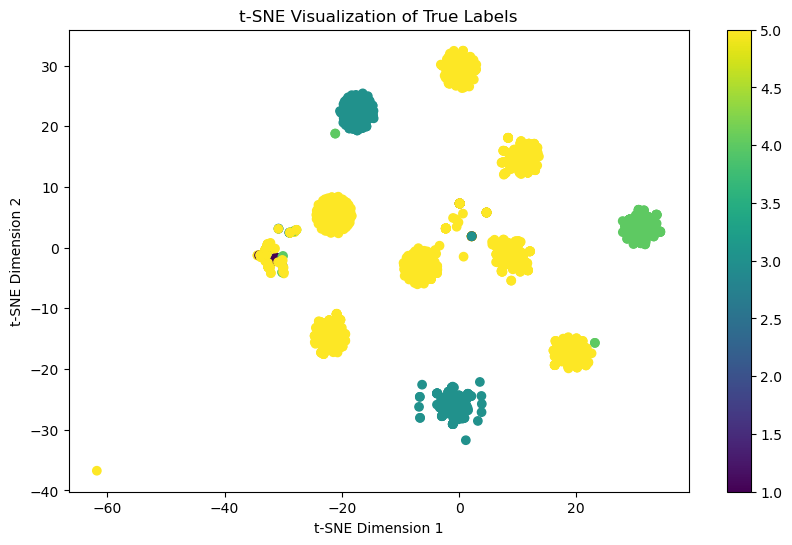

In [4]:
## using t-sne (alternative to pca) to visualize clusters according to true labels

# Calculate cosine distances between binary vectors
cosine_distances_matrix = cosine_distances(itemset_features)

# Create a t-SNE instance with cosine distance
tsne = TSNE(n_components=2, metric="precomputed", perplexity=30, learning_rate=200, init="random")

# Fit t-SNE to the cosine distance matrix
tsne_results = tsne.fit_transform(cosine_distances_matrix)

# Create a scatter plot to visualize the results
plt.figure(figsize=(10, 6))


plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=true_labels, cmap='viridis')
plt.colorbar()
plt.title('t-SNE Visualization of True Labels')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()


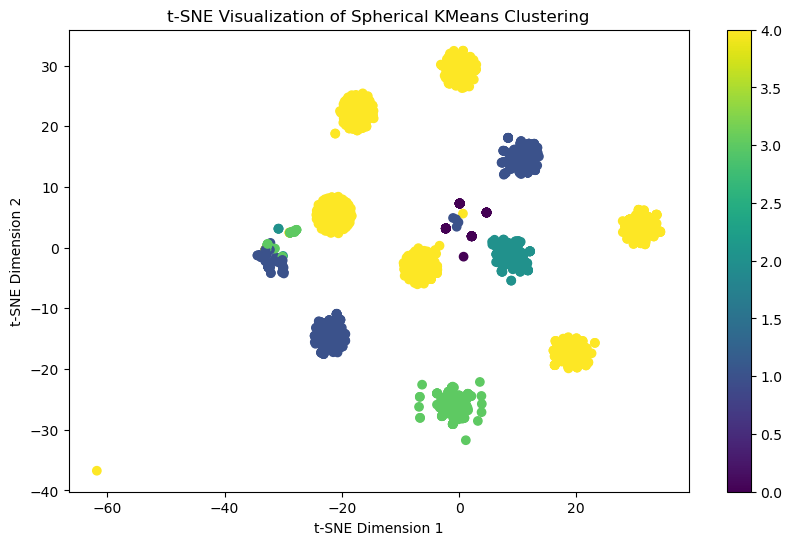

In [5]:
## using t-sne (alternative to pca) to visualize Spherical KMeans clusters

# Create a scatter plot to visualize the results
plt.figure(figsize=(10, 6))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=sphkmeans_cluster_labels, cmap='viridis')
plt.colorbar()
plt.title('t-SNE Visualization of Spherical KMeans Clustering')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()


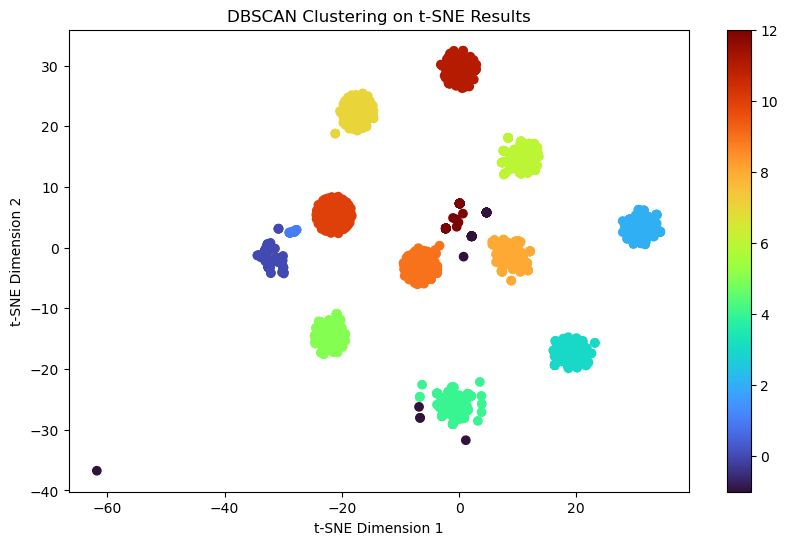

Adjusted Rand Index: 0.13873942880070853
Normalized Mutual Information: 0.45197960419187183
Homogeneity: 0.3011329167372309
Completeness: 0.9056447631014239
V-Measure: 0.4519796041918718
Silhouette Score: 0.0054026732620274425


array([0.13873943, 0.4519796 , 0.30113292, 0.90564476, 0.4519796 ,
       0.00540267])

In [6]:
## performing DBSCAN on the data transformed by t-sne

from sklearn.cluster import DBSCAN

# Apply DBSCAN to the t-SNE results
dbscan = DBSCAN(eps=3, min_samples=20)
dbscan_labels = dbscan.fit_predict(tsne_results)

# Create a scatter plot to visualize the DBSCAN clustering results
plt.figure(figsize=(10, 6))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=dbscan_labels, cmap='turbo')
plt.colorbar()
plt.title('DBSCAN Clustering on t-SNE Results')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

compare_true_labels(dbscan_labels, true_labels, itemset_features)

In [7]:
## REMOVE OUTLIERS IDEA

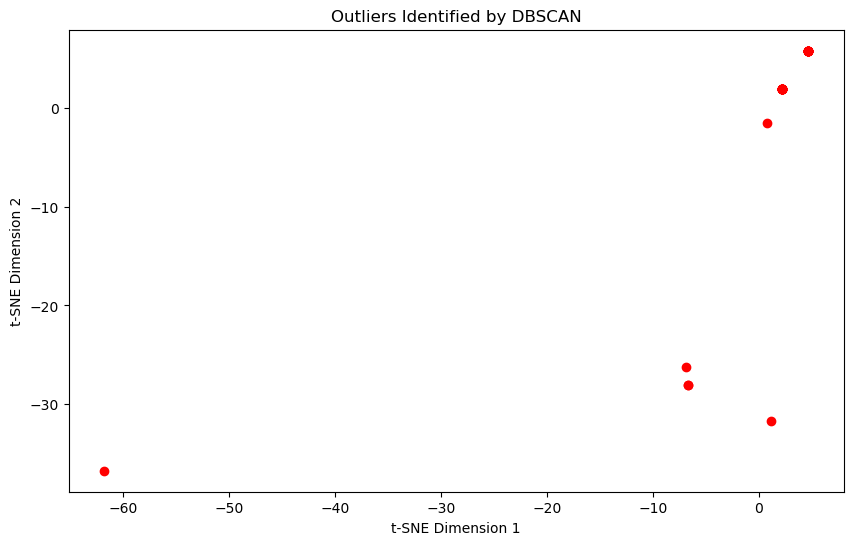

In [8]:
# Filter out the outlier points
outlier_points = tsne_results[dbscan_labels == -1]

# Create a scatter plot for the outliers
plt.figure(figsize=(10, 6))
plt.scatter(outlier_points[:, 0], outlier_points[:, 1], color='red')
plt.title('Outliers Identified by DBSCAN')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

In [9]:
outlier_index = np.where(dbscan_labels==-1)

filtered_data = np.delete(itemset_features, outlier_index, axis=0)
filtered_labels = np.delete(true_labels, outlier_index, axis=0)
print(len(filtered_labels), len(true_labels))

# convert itemset_features to a sparse matrix that SphericalKMeans will accept
filtered_itemset_matrix = csr_matrix(filtered_data.astype(int))

spherical_kmeans = SphericalKMeans(
        n_clusters=11,
        max_iter=100,
        verbose=0,
        init='similar_cut',
        #sparsity='minimum_df',
        minimum_df_factor=0.05
    )

results = []
i = 0

while len(results)<10:
    try:
        i+=1
        print('\nRun #' + str(i))
        filtered_sphkmeans_cluster_labels = spherical_kmeans.fit_predict(filtered_itemset_matrix)
        result = compare_true_labels(filtered_labels, filtered_sphkmeans_cluster_labels, filtered_data)
        results.append(result)
    except Exception as e:
        # sometimes spherical clustering fails due to the initialization, re-run
        print(e)
        continue 

2231 2269

Run #1
Adjusted Rand Index: 0.06547392896046382
Normalized Mutual Information: 0.31223353667615245
Homogeneity: 0.5012300782680721
Completeness: 0.22673834291967773
V-Measure: 0.31223353667615245
Silhouette Score: 0.6281400352443778

Run #2
Input contains infinity or a value too large for dtype('float64').

Run #3
Adjusted Rand Index: -0.008749033717531805
Normalized Mutual Information: 0.2587615836795841
Homogeneity: 0.39641728348524174
Completeness: 0.19206656633430144
V-Measure: 0.2587615836795841
Silhouette Score: 0.5947837141998196

Run #4
Input contains infinity or a value too large for dtype('float64').

Run #5
Adjusted Rand Index: 0.1057384281065971
Normalized Mutual Information: 0.4039985170368978
Homogeneity: 0.7118266104994989
Completeness: 0.28203360795743276
V-Measure: 0.4039985170368979
Silhouette Score: 0.5950686775803299

Run #6
Input contains infinity or a value too large for dtype('float64').

Run #7
Adjusted Rand Index: 0.030875896673275647
Normalized Mutu

In [10]:
results = np.array(results)
column_medians = np.median(results, axis=0)

print("Median values")
print("ARI: " + str(column_medians[0]))
print("NMI: " + str(column_medians[1]))
print("Homogeneity: " + str(column_medians[2]))
print("Completeness: " + str(column_medians[3]))
print("V-Measure: " + str(column_medians[4]))
print("Silhouette: " + str(column_medians[5]))

Median values
ARI: 0.06913891922407403
NMI: 0.3116652872698773
Homogeneity: 0.47319874020184016
Completeness: 0.22994761538096925
V-Measure: 0.3116652872698773
Silhouette: 0.5466184671805879


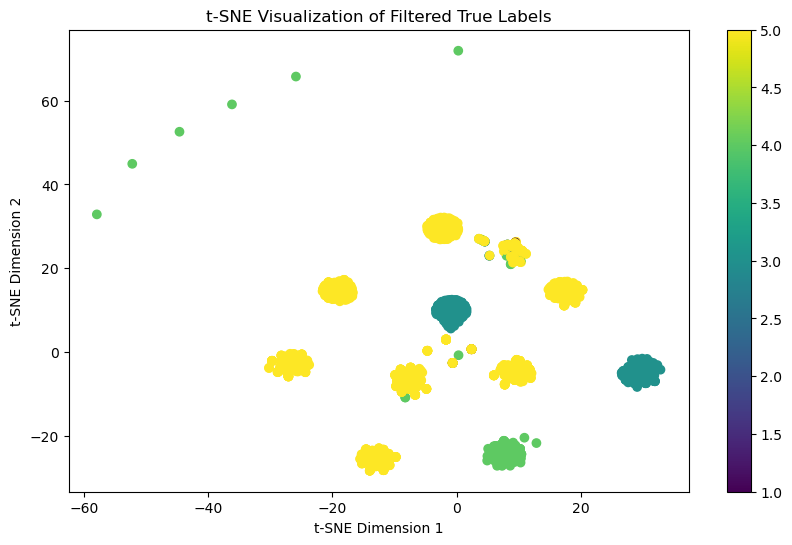

In [11]:
## using t-sne (alternative to pca) to visualize filtered true clusters

# Calculate cosine distances between binary vectors
cosine_distances_matrix = cosine_distances(filtered_data)

# Create a t-SNE instance with cosine distance
tsne = TSNE(n_components=2, metric="precomputed", perplexity=30, learning_rate=200, init="random")

# Fit t-SNE to the cosine distance matrix
tsne_results = tsne.fit_transform(cosine_distances_matrix)

# Create a scatter plot to visualize the results
plt.figure(figsize=(10, 6))


plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=filtered_labels, cmap='viridis')
plt.colorbar()
plt.title('t-SNE Visualization of Filtered True Labels')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()


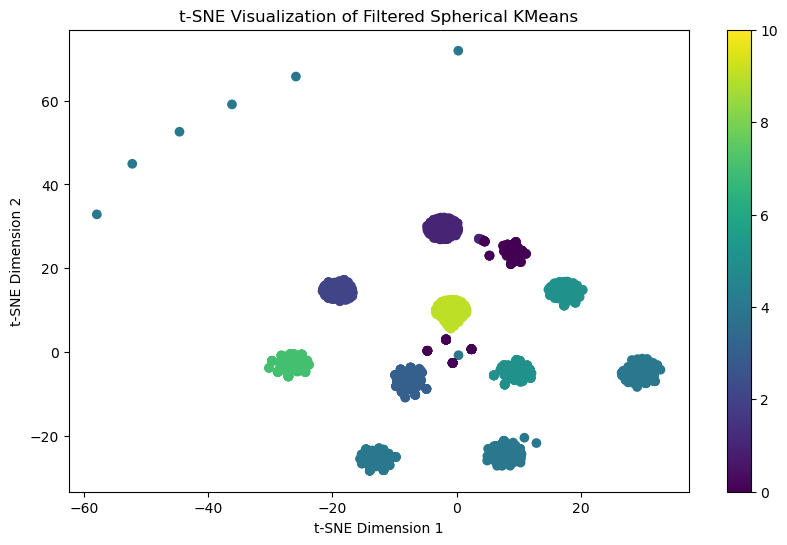

In [12]:
## using t-sne (alternative to pca) to visualize filtered SPHKMEANS clusters

# Create a scatter plot to visualize the results
plt.figure(figsize=(10, 6))

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=filtered_sphkmeans_cluster_labels, cmap='viridis')
plt.colorbar()
plt.title('t-SNE Visualization of Filtered Spherical KMeans')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()
